# Simple 2D examples.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad

import numpy as np
import matplotlib.pyplot as plt




### Base example, classify point in and out of a circle in 2D.

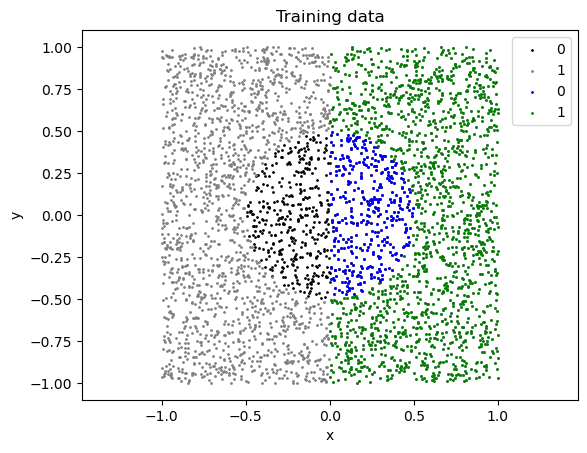

In [11]:
## Generate the dataset
np.random.seed(98235)
torch.manual_seed(98235)


N = 4000  # number of data points

# Training data
train_data = np.random.rand(N, 2) * 2 - 1  # Generate random points in [-1, 1] x [-1, 1]
train_labels = np.sqrt(train_data[:, 0]**2 + train_data[:, 1]**2) > 1/2  # Calculate r and assign labels
train_labels = train_labels.astype(np.float32)




# Partial data, only x>0
mask = (train_data[:, 0] > 0)

train_data_restriced = train_data[mask]
train_labels_restriced = train_labels[mask]



# Plot the data
plt.figure()
plt.scatter(train_data[train_labels == 0, 0], train_data[train_labels == 0, 1], s=1, label='0', c='k')
plt.scatter(train_data[train_labels == 1, 0], train_data[train_labels == 1, 1], s=1, label='1', c='gray')
plt.scatter(train_data_restriced[train_labels_restriced == 0, 0], train_data_restriced[train_labels_restriced == 0, 1], s=1, label='0', c='b')
plt.scatter(train_data_restriced[train_labels_restriced == 1, 0], train_data_restriced[train_labels_restriced == 1, 1], s=1, label='1', c='g')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data')
plt.legend()
plt.show()



In [12]:
# Test data, same distribution as training data, slightly smaller
test_data = np.random.rand(N//5, 2) * 2 - 1
test_labels = np.sqrt(test_data[:, 0]**2 + test_data[:, 1]**2) > 1/2
test_labels = test_labels.astype(np.float32)

In [13]:
# Convert to PyTorch tensors and create loaders
train_data = torch.tensor(train_data, dtype=torch.float32,requires_grad=True)
train_labels = torch.tensor(train_labels, dtype=torch.float32,requires_grad=True)

test_data = torch.tensor(test_data, dtype=torch.float32,requires_grad=True)
test_labels = torch.tensor(test_labels, dtype=torch.float32,requires_grad=True)

train_data_restriced = torch.tensor(train_data_restriced, dtype=torch.float32,requires_grad=True)
train_labels_restriced = torch.tensor(train_labels_restriced, dtype=torch.float32,requires_grad=True)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_dataset_restricted = TensorDataset(train_data_restriced, train_labels_restriced)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader_restricted = DataLoader(train_dataset_restricted, batch_size=32, shuffle=True)

Epoch 1, train loss: 0.225, test loss: 0.211
Epoch 101, train loss: 0.147, test loss: 0.141
Epoch 201, train loss: 0.012, test loss: 0.011
Epoch 301, train loss: 0.006, test loss: 0.007
Epoch 401, train loss: 0.005, test loss: 0.004
Epoch 501, train loss: 0.004, test loss: 0.004
Epoch 601, train loss: 0.003, test loss: 0.003
Epoch 701, train loss: 0.003, test loss: 0.005
Epoch 801, train loss: 0.003, test loss: 0.002
Epoch 901, train loss: 0.003, test loss: 0.002
Epoch 1, train loss restricted: 0.233, test loss restricted: 0.222
Epoch 101, train loss restricted: 0.114, test loss restricted: 0.143
Epoch 201, train loss restricted: 0.024, test loss restricted: 0.204
Epoch 301, train loss restricted: 0.013, test loss restricted: 0.226
Epoch 401, train loss restricted: 0.009, test loss restricted: 0.223
Epoch 501, train loss restricted: 0.007, test loss restricted: 0.213
Epoch 601, train loss restricted: 0.005, test loss restricted: 0.208
Epoch 701, train loss restricted: 0.005, test loss 

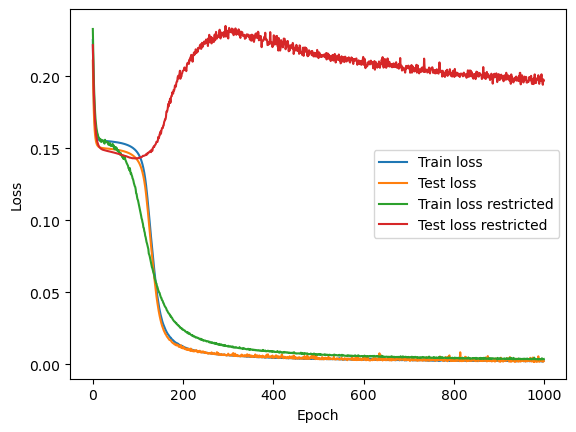

In [14]:
# Define the model
class Net(nn.Module):
    def __init__(self,n_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 1)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x
    

    
model = Net()
model_restricted = Net()


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
test_loss = []


for epoch in range(1000):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    model.eval()
    running_loss = 0.0
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        running_loss += loss.item()
    test_loss.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss: {train_loss[-1]:.3f}, test loss: {test_loss[-1]:.3f}")

# Train the model on the restricted data
train_loss_restricted = []
test_loss_restricted = []

for epoch in range(1000):
    model_restricted.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader_restricted):
        inputs, labels = data
        optimizer_restricted.zero_grad()
        outputs = model_restricted(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_restricted.step()
        running_loss += loss.item()
    train_loss_restricted.append(running_loss / len(train_loader_restricted))
    
    model_restricted.eval()
    running_loss = 0.0
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model_restricted(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        running_loss += loss.item()
    test_loss_restricted.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss restricted: {train_loss_restricted[-1]:.3f}, test loss restricted: {test_loss_restricted[-1]:.3f}")


# Plot the loss 

plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.plot(train_loss_restricted, label="Train loss restricted")
plt.plot(test_loss_restricted, label="Test loss restricted")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [6]:
def evaluate_model(model, data, SO2_gen):
    # Forward pass
    rand_data=torch.randn_like(data,requires_grad=True)
    outputs = model(rand_data).squeeze()  # Ensure output is correctly squeezed for binary classification

    
    # Compute gradients
    grad_outputs = torch.ones_like(outputs)  # Same shape as model output
    gradients = grad(outputs=outputs, inputs=rand_data,
                     grad_outputs=grad_outputs, create_graph=True)[0]

    # Perform matrix multiplication with SO(2) generator and then with the input data
    result = torch.matmul(torch.matmul(gradients, SO2_gen), data.unsqueeze(-1))

    # Assuming the result tensor is [N, 2, 1], flatten for mean and std calculation
    result_flattened = result.view(-1)

    # Compute and return mean and standard deviation
    return result_flattened.mean().item(), result_flattened.std().item()

# Assuming SO2_gen and train_data_restriced are defined and set up correctly
SO2_gen = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)
train_data.requires_grad_(True)  # Ensure gradients are computed for the input data

# Evaluate both models
mean_std_model = evaluate_model(model, train_data, SO2_gen)
mean_std_model_restricted = evaluate_model(model_restricted, train_data, SO2_gen)

print(f"Model: Mean = {mean_std_model[0]}, Std = {mean_std_model[1]}")
print(f"Model (Restricted): Mean = {mean_std_model_restricted[0]}, Std = {mean_std_model_restricted[1]}")
train_data.requires_grad_(False);  # Ensure gradients are computed for the input data


Model: Mean = 0.00020160494023002684, Std = 2.146681308746338
Model (Restricted): Mean = 0.0001241267309524119, Std = 1.5594078302383423


In [9]:
# Train a new model like beore, on the restricted data, but add the SO(2) invariance loss term

model_restricted_SO2 = Net()

# Assuming criterion and optimizer_restricted are defined
criterion = nn.MSELoss()
optimizer_restricted = torch.optim.Adam(model_restricted_SO2.parameters(), lr=0.001)

train_loss_restricted_SO2 = []
test_loss_restricted_SO2 = []

for epoch in range(1000):
    model_restricted_SO2.train()
    running_loss = 0.0
    for inputs, labels in train_loader_restricted:
        rand_in=torch.randn_like(inputs,requires_grad=True)
        optimizer_restricted.zero_grad()
        outputs = model_restricted_SO2(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Adjusted to ensure correct dimensionality
        
        # Compute gradients with respect to inputs
        grad_outputs = torch.ones_like(outputs.squeeze())
        gradients = grad(outputs=outputs.squeeze(), inputs=rand_in, 
                 grad_outputs=grad_outputs, create_graph=True)[0]

        # Perform matrix multiplication with SO(2) generator and then with the input data
        result = torch.matmul(torch.matmul(gradients, SO2_gen), inputs.unsqueeze(-1))

        # Assuming the result tensor is [N, 2, 1], calculate the standard deviation
        result_flattened = result.view(-1)
        loss += 0.1*result_flattened.std()

        loss.backward()
        optimizer_restricted.step()
        running_loss += loss.item()
    train_loss_restricted_SO2.append(running_loss / len(train_loader_restricted))

    model_restricted_SO2.eval()
    running_loss = 0.0
    for inputs, labels in test_loader:
        inputs.requires_grad_(True)
        outputs = model_restricted_SO2(inputs)
        loss = criterion(outputs.squeeze(), labels)
        running_loss += loss.item()
    test_loss_restricted_SO2.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss restricted SO2: {train_loss_restricted_SO2[-1]:.3f}, test loss restricted SO2: {test_loss_restricted_SO2[-1]:.3f}")

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss_restricted_SO2, label="Train Loss with SO2 Term")
plt.plot(test_loss_restricted_SO2, label="Test Loss with SO2 Term")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


AttributeError: 'int' object has no attribute 'Linear'

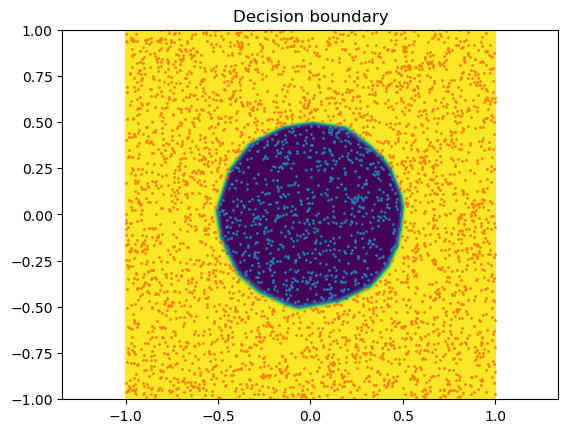

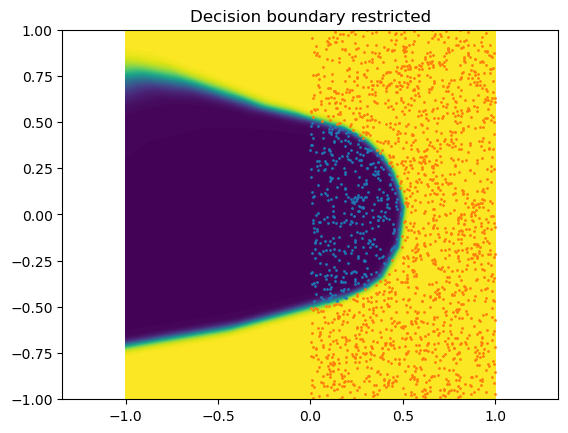

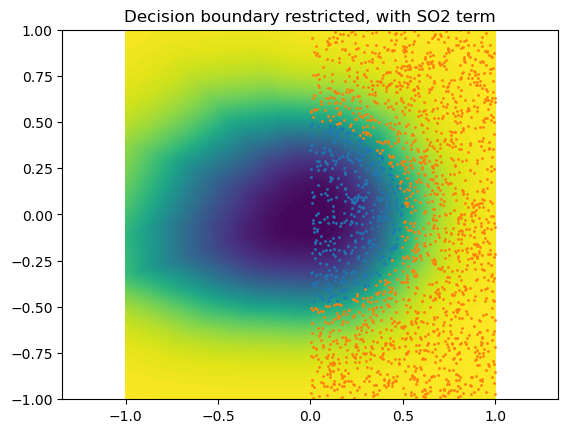

In [8]:
# Plot the decision boundary for both models
nn=300

x = np.linspace(-1, 1, nn)
y = np.linspace(-1, 1, nn)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).detach().numpy()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data[train_labels == 0, 0], train_data[train_labels == 0, 1], s=1)
plt.scatter(train_data[train_labels == 1, 0], train_data[train_labels == 1, 1], s=1)
plt.axis('equal')
plt.title("Decision boundary")
plt.show()

Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model_restricted(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).item()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data_restriced[train_labels_restriced == 0, 0].detach().numpy(), train_data_restriced[train_labels_restriced == 0, 1].detach().numpy(), s=1)
plt.scatter(train_data_restriced[train_labels_restriced == 1, 0].detach().numpy(), train_data_restriced[train_labels_restriced == 1, 1].detach().numpy(), s=1)
plt.axis('equal')
plt.title("Decision boundary restricted")
plt.show()



Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model_restricted_SO2(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).item()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data_restriced[train_labels_restriced == 0, 0].detach().numpy(), train_data_restriced[train_labels_restriced == 0, 1].detach().numpy(), s=1)
plt.scatter(train_data_restriced[train_labels_restriced == 1, 0].detach().numpy(), train_data_restriced[train_labels_restriced == 1, 1].detach().numpy(), s=1)
plt.axis('equal')
plt.title("Decision boundary restricted, with SO2 term")
plt.show()


